### Домашнее задание

#### Задание 1.
Самостоятельно разобраться с тем, что такое tfidf (документация

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html 

и еще - 
https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

#### Задание 2.
Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. 
Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

#### Задание 3.
Повторить п.2, но используя уже не медиану, а max

<b> Задание 4. </b> (опциональное, если очень хочется)

Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). 
Подсказка 2 - нужен именно idf, как вес.

#### Задание 5.
Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

#### Задание 6.
Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Ссылки
http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

Библиотеки, которые нужно установить:

gensim

razdel

pymorphy2

nltk

<b>Дано три датасета:</b>

1) Новости: id и текст самой новости;

2) Список новостей, которые прочел пользователь: uid и список id статей, которые он прочел;

3) Информация об оттоке: uid, churn;

In [14]:
import pandas as pd

Загружаем датасет с новостями (1)

In [15]:
news = pd.read_csv("/Users/ekaterina/Desktop/LEARN/IT/Машинное обучение в бизнесе/lection2_materials/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим датасет с пользователями и списками последних прочитанных новостей

In [16]:
users = pd.read_csv("/Users/ekaterina/Desktop/LEARN/IT/Машинное обучение в бизнесе/lection2_materials/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Загрузим данные по оттоку клиентов - таргет

In [17]:
target = pd.read_csv("/Users/ekaterina/Desktop/LEARN/IT/Машинное обучение в бизнесе/lection2_materials/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

In [7]:
pip install gensim


     |████████████████████████████████| 24.0 MB 196 kB/s eta 0:00:01
     |████████████████████████████████| 58 kB 644 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install razdel


Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install pymorphy2


     |████████████████████████████████| 55 kB 914 kB/s eta 0:00:01
     |████████████████████████████████| 8.2 MB 1.7 MB/s eta 0:00:01     |███████████▋                    | 3.0 MB 1.7 MB/s eta 0:00:04
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13703 sha256=076f1f9df9cb8f697043afb1f11935291cd06f757f61736885429028a0c1780e
  Stored in directory: /Users/ekaterina/Library/Caches/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


### 1. Получаем векторные представления новостей

In [18]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [25]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ekaterina/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
# загрузим стоп слова русского языка
stopword_ru = stopwords.words('russian')
len(stopword_ru)

# Создаем морфологический анализатор (позволяет привести слова с разными окончаниями к общей форме)
morph = pymorphy2.MorphAnalyzer()

In [28]:
# добавим к стоп-словам еще один список из нашего дополнительного файла

with open('/Users/ekaterina/Desktop/LEARN/IT/Машинное обучение в бизнесе/lection2_materials/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [29]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [30]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-29-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 24.3 s, sys: 570 ms, total: 24.9 s
Wall time: 25.8 s


In [31]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 11s, sys: 1.89 s, total: 3min 13s
Wall time: 3min 21s


А теперь в 3 строчки обучим нашу модель

In [32]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [33]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
# создаем словарь из всех встречающихся в датасете слов
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts] #формируем bag of words



Запускаем обучение

In [34]:
from gensim.models import LdaModel

In [35]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=20, id2word=common_dictionary)#, passes=10)

CPU times: user 37.3 s, sys: 2.4 s, total: 39.7 s
Wall time: 26.2 s


In [36]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

как выглядят наши темы

как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [37]:
# Create a new corpus, made of previously unseen documents.
# сформируем новый мешок слов из документов, которые ранее не были задействованы

other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(0, 0.33680332), (2, 0.32156652), (8, 0.19584252), (10, 0.12424273)]

In [38]:
x=lda.show_topics(num_topics=20, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: лекарство польша польский остановка заблокировать рим завести застрять си лауреат
topic_1: северный японский япония южный корея сон таиланд ким сближение японец
topic_2: гражданин население граница остров район правительство россия российский документ регион
topic_3: фонд женщина университет nn жизнь обнаружить писать мужчина всё выяснить
topic_4: взрыв британский великобритания лондон помещение поиск австралийский источник берег армения
topic_5: ребёнок смерть семья родитель рейс космос газета долг область земля
topic_6: nn рубль сотрудник россия рак млн задержать рф источник тыс
topic_7: газ россия nn закон российский санкция власть продукция фестиваль украина
topic_8: ракета первый министерство новый nn день поверхность система автор выяснить
topic_9: погибнуть пострадать участок данные территория восток расследование район аэропорт информация
topic_10: исследование всё день тело помощь земля первый вода планета произойти
topic_11: украина россия журнал всё nn риск украинск

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [39]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(20):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [40]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(20)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(20)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.085589,0.113045,0.000000,...,0.013280,0.000000,0.0,0.12543,0.000000,0.000000,0.0,0.000000,0.425665,0.230292
1,4896,0.289936,0.0,0.000000,0.0,0.440925,0.0,0.187256,0.000000,0.000000,...,0.000000,0.000000,0.0,0.00000,0.060827,0.000000,0.0,0.000000,0.000000,0.000000
2,4897,0.336763,0.0,0.321527,0.0,0.000000,0.0,0.000000,0.000000,0.195958,...,0.124207,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,4898,0.094150,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.840441,0.0,0.00000,0.000000,0.000000,0.0,0.054746,0.000000,0.000000
4,4899,0.068111,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.00000,0.000000,0.110886,0.0,0.000000,0.000000,0.759337


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [41]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [42]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(20)]].values))

In [43]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.40083712, 0.        ,
       0.        , 0.        , 0.10715021, 0.11982137, 0.        ,
       0.07872738, 0.        , 0.06067636, 0.06087094, 0.        ,
       0.14080726, 0.02092538, 0.        , 0.        , 0.        ])

In [44]:
user_articles_list = users['articles'].iloc[33]

# Функция для получения вектора пользователя по темам прочитанных статей
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [45]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.04573711, 0.14909103, 0.        ,
       0.05499482, 0.13319228, 0.13111548, 0.0714255 , 0.01282245,
       0.01480217, 0.04791474, 0.        , 0.        , 0.00172988,
       0.0555371 , 0.00362464, 0.01369732, 0.13920369, 0.11523407])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [ ]:
#users['articles'].iloc[33]

In [ ]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [46]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(20)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(20)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.000000,0.004765,0.037083,0.129815,0.019911,0.162331,0.024523,0.036279,0.022465,...,0.066522,0.069340,0.010113,0.138559,0.000000,0.097037,0.003488,0.019770,0.055590,0.062553
1,u108690,0.004691,0.000000,0.041712,0.129849,0.000000,0.069678,0.112757,0.046535,0.022487,...,0.077990,0.201239,0.002269,0.039384,0.002936,0.096120,0.006434,0.032901,0.054787,0.017225
2,u108339,0.001946,0.000000,0.072298,0.038815,0.002188,0.054359,0.118563,0.087607,0.012614,...,0.134072,0.061164,0.002755,0.079492,0.011933,0.060470,0.000000,0.027223,0.111817,0.032163


In [47]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.000000,0.004765,0.037083,0.129815,0.019911,0.162331,0.024523,0.036279,0.022465,...,0.069340,0.010113,0.138559,0.000000,0.097037,0.003488,0.019770,0.055590,0.062553,0
1,u108690,0.004691,0.000000,0.041712,0.129849,0.000000,0.069678,0.112757,0.046535,0.022487,...,0.201239,0.002269,0.039384,0.002936,0.096120,0.006434,0.032901,0.054787,0.017225,1
2,u108339,0.001946,0.000000,0.072298,0.038815,0.002188,0.054359,0.118563,0.087607,0.012614,...,0.061164,0.002755,0.079492,0.011933,0.060470,0.000000,0.027223,0.111817,0.032163,1


In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [49]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(20)]], 
                                                    X['churn'], random_state=0)

In [50]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [51]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.06759798, 0.0698297 , 0.3828405 , 0.24302738, 0.08007907,
       0.06846699, 0.16555704, 0.24321155, 0.08803302, 0.03996591])

In [52]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score¶

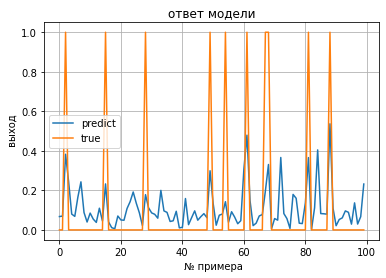

In [53]:
plt.plot( preds[:100], label = 'predict')
plt.plot(y_test.values[:100], label = 'true')
plt.title('ответ модели')
plt.xlabel(' № примера')
plt.ylabel(' выход')
plt.legend()
plt.grid('On')
plt.show()

По графику видно, что threshold должен быть существенно ниже 0.5. Получим его лучшее значение ниже:

In [54]:
precision, recall, thresholds = precision_recall_curve(y_test.values[:1000], preds[:1000])

fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix_ = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix_], 
                                                                        fscore[ix_],
                                                                        precision[ix_],
                                                                        recall[ix_]))

Best Threshold=0.245247, F-Score=0.676, Precision=0.613, Recall=0.754


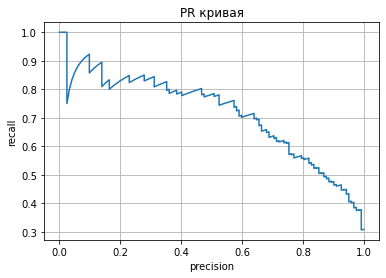

In [55]:
plt.plot(recall,precision )
plt.title('PR кривая')
plt.xlabel('precision')
plt.ylabel('recall')
plt.grid('On')
plt.show()

In [56]:
import itertools

In [57]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1634  121]
 [  55  190]]


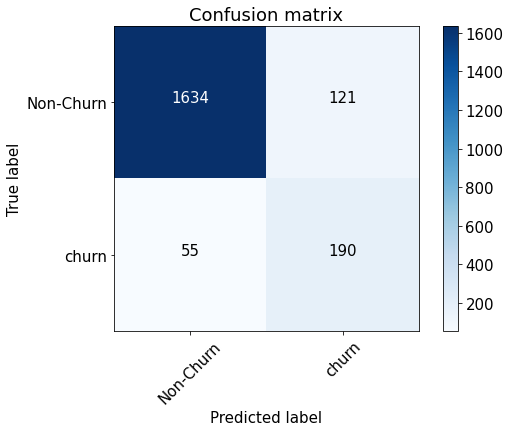

In [61]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix_])
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [62]:
roc_auc_score_ = roc_auc_score(y_test, preds)
roc_auc_score_

0.951606488749346

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу.

#### Задание 2.

Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [63]:
# Функция для получения вектора пользователя по темам прочитанных статей с использованием МЕДИАНЫ
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector1 = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector1 = np.median(user_vector1, 0)
    return user_vector1

In [64]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(20)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(20)]]

X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.0,0.0,0.015302,0.100360,0.0,0.058829,0.000000,0.000000,0.000000,...,0.000000,0.0,0.093197,0.0,0.056030,0.0,0.000000,0.000000,0.024270,0
1,u108690,0.0,0.0,0.050680,0.152248,0.0,0.056230,0.096369,0.033163,0.006440,...,0.167965,0.0,0.031008,0.0,0.048831,0.0,0.011148,0.056783,0.014014,1
2,u108339,0.0,0.0,0.062654,0.038724,0.0,0.045707,0.114035,0.070997,0.009957,...,0.063042,0.0,0.069943,0.0,0.043702,0.0,0.014073,0.065515,0.000000,1


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(20)]], 
                                                    X['churn'], random_state=0)


In [66]:
logreg = LogisticRegression(C=1.0)
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]

In [67]:
precision1, recall1, thresholds1 = precision_recall_curve(y_test.values[:1000], preds[:1000])

fscore1 = (2 * precision1 * recall1) / (precision1 + recall1)

# locate the index of the largest f score
ix1 = np.argmax(fscore1)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds1[ix1], 
                                                                        fscore1[ix1],
                                                                        precision1[ix1],
                                                                        recall1[ix1]))

Best Threshold=0.319402, F-Score=0.839, Precision=0.825, Recall=0.852


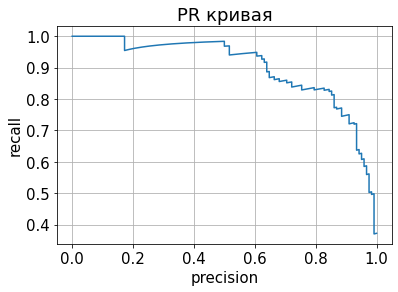

In [68]:
plt.plot(recall1,precision1 )
plt.title('PR кривая')
plt.xlabel('precision')
plt.ylabel('recall')
plt.grid('On')
plt.show()

Confusion matrix, without normalization
[[1735   20]
 [  84  161]]


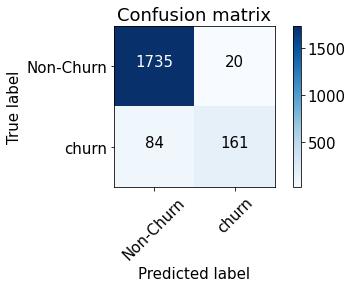

In [81]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds1[ix_])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [71]:
roc_auc_score1 = roc_auc_score(y_test, preds)
roc_auc_score1

0.9805058433629863

#### Задание 3

Повторить п.2, но используя уже не медиану, а max

In [72]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector1 = np.max(user_vector, 0)  
    return user_vector1

In [73]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(20)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(20)]]

X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.000000,0.028587,0.156108,0.400837,0.071764,0.537452,0.147138,0.110523,0.119821,...,0.305522,0.060676,0.382515,0.000000,0.329358,0.020925,0.118619,0.289456,0.205903,0
1,u108690,0.028148,0.000000,0.078923,0.194408,0.000000,0.187523,0.290287,0.122349,0.077208,...,0.366286,0.013613,0.109461,0.017615,0.310018,0.038604,0.113441,0.115311,0.042063,1
2,u108339,0.011673,0.000000,0.157049,0.077761,0.013129,0.135870,0.229056,0.263456,0.032070,...,0.129120,0.016528,0.129816,0.039211,0.163206,0.000000,0.067716,0.354586,0.139323,1


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(20)]], 
                                                    X['churn'], random_state=0)

In [75]:
precision2, recall2, thresholds2 = precision_recall_curve(y_test.values[:1000], preds[:1000])

fscore2 = (2 * precision2 * recall2) / (precision2 + recall2)

# locate the index of the largest f score
ix2 = np.argmax(fscore2)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds2[ix2], 
                                                                        fscore2[ix2],
                                                                        precision2[ix2],
                                                                        recall2[ix2]))


Best Threshold=0.319402, F-Score=0.839, Precision=0.825, Recall=0.852


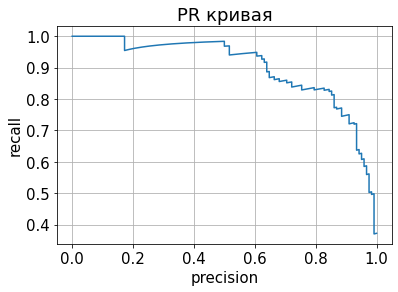

In [76]:
plt.plot(recall2,precision2 )
plt.title('PR кривая')
plt.xlabel('precision')
plt.ylabel('recall')
plt.grid('On')
plt.show()

Confusion matrix, without normalization
[[1735   20]
 [  84  161]]


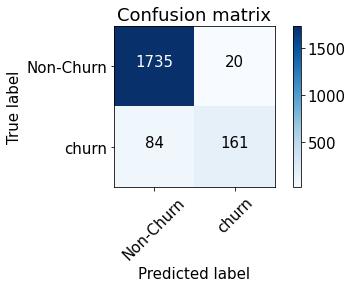

In [82]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds1[ix_])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [79]:
roc_auc_score2 = roc_auc_score(y_test, preds)
roc_auc_score2

0.9805058433629863

#### Задание 5

Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [80]:
evaluation = pd.DataFrame({
    'тип усреднения': ['mean', 'median', 'max'],
    'precision': [precision[ix_], precision1[ix1], precision2[ix2]],
    'recall': [recall[ix_], recall1[ix1], recall2[ix2]],
    'F score': [fscore[ix_], fscore1[ix1], fscore2[ix2]],
    'ROC-AUC score': [roc_auc_score_, roc_auc_score1, roc_auc_score2],
})

evaluation

,тип усреднения,precision,recall,F score,ROC-AUC score
0,mean,0.613333,0.754098,0.676471,0.951606
1,median,0.825397,0.852459,0.838710,0.980506
2,max,0.825397,0.852459,0.838710,0.980506


#### Задание 6

Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Высокие значения метрик достигаются при разбиении на 20 тем и при использовании максимального значения среди вероятностей каждой темы при формировании вектора пользователя. 
Очевидно, что выбор максимального значения среди вероятностей тематик - наиболее удачный.
Если мы выбираем среднее, то сильно падают показатели полноты (recall) и f-меры, то есть падает качество классификации - мы менее точно предсказываем количество покинувших портал пользователей, частично их пропуская.
Среднее и медиана предполагают возможность снижения вероятности чтения темы, которую пользователь действительно читает (если в случае среднего все вероятности участвуют в формировании результата, то в случае медианы остается только одно значение из середины, а остальные не участвуют вообще, таким образом мы их теряем, то есть теоретическим можем потерять действительно читаемую пользователем тему).